# Demo: tests using simulations

This demo is concerned with tests run using simulations done using plain Numpy and SciPy (rather than PyTorch, as in our other tests). The goal is to give the user sufficient information to accurately reproduce the results obtained in the following references.

- Robustness and scalability under heavy tails, without strong convexity. Matthew J. Holland. *AISTATS 2021*.
- Scaling-Up Robust Gradient Descent Techniques. Matthew J. Holland. *AAAI 2021*.
- <a href="https://arxiv.org/abs/2012.07346">Better scalability under potentially heavy-tailed feedback</a> (__Sections 4.1 and 4.2__). Matthew J. Holland. *Archival version*.

The contents of this demonstration are as follows:

- <a href="#guide">Guide to running the experiments</a>

- <a href="#prelim">Visualize: preliminaries</a>

- <a href="#onetrial">Visualize: a single-trial</a>
  - Weak sub-processes
  - Boosted candidates
  
- <a href="#multitrial">Visualize: boosted candidates over multiple trials</a>
  - Single task, single model

We first give some details on actually running the tests. The remainder of this demo aids the user in producing visuals based on the experimental test results.


___

<a id="guide"></a>
## Guide to running the experiments

Please see the README file of this repository for a high-level description of the experiments of interest here. We assume that the user has already read and done the relevant preparations described in the section "Setup: software for simulations" from the README. Here we simply fill in the remaining details surrounding experiment settings.


### Glossary of experimental parameters

- `--algo`: type of algorithm to be used (e.g., SGD, SGDAve, etc.).

- `--batch-size`: number of data points used in each iteration.

- `--data`: the name of the data generation protocol to be used.

- `--loss`: type of loss to be used for learning.

- `--model`: type of model to be used (e.g., linear regression).

- `--num-epochs`: the number of passes to make over the data set.

- `--num-processes`: the number of weak sub-routines to be run.

- `--num-trials`: the number of trials to be run.

- `--step-size`: when relevant, this is a step size coefficient iterative gradient-based algorithms. The exact step size setting is determined within `setup_algos.py`.

- `--task-name`: the name we choose to distinguish a particular task from others.


### Detailed parameter settings

A quick glance at the description of our experimental setup given in the papers referenced above will show that we considered a very wide variety of settings. To keep this repository lightweight and sufficiently easy to use, we have chosen not to clutter it with every possible variation, instead providing the user with a general-purpose driver script and a few representative examples that show clearly how the tests done in the paper can be re-created.

Here we discuss all the key parameters that we controlled, and describe where the user should look in this repository to customize each parameter.

- __True underlying model:__ this is determined (called `w_star`) by the data-generating procedure specified in `setup_data.py`.

- __Initialization error:__ the degree of noise is specified as part of the data protocol parameters (`dataset_paras` defined in `setup_data.py`). The actual initialization is done in the driver script by calling `get_w_init` defined in `setup_inits.py`. Having the initialization error depend in a controlled fashion on the dimension is easily implemented in `setup_inits.py`.

- __Sample size, dimension, noise level:__ all these parameters are determined in one location, namely the `dataset_paras` dictionary defined in `setup_data.py`. For reference, we have provided two working examples (called `ds_normal` and `ds_lognormal`) using Normal and log-Normal noise, under exactly the same settings as tested in Section 4.1 (E1) of the second paper cited at the head of this document.

- __Robust boosting techniques:__ the techniques to be used are specified in the list called `todo_roboost`, defined in `setup_roboost.py`. All high-level details are specified here, for methods using both "Merge" and "Valid" sub-routines (recalling the terminology from the cited papers).


### Execution

For each experimental setting specified in `learn_run.sh`, running all trials is a one line command:

```
(sgd-roboost) $ ./learn_run.sh
```

Note that for multiple tasks with many common settings, a looping script can easily be written (see "Demo: tests using benchmark data" for an example). Once all the tests have been run, the results should be written to disk in the specified location; one file per combination of experimental setting, method, and trial number. In the following section, we process and visualize these results.


___

<a id="prelim"></a>
## Visualize: preliminaries

In [1]:
## External modules.
from contextlib import ExitStack
import json
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os

## Internal modules.
from mml.utils import makedir_safe
from setup_data import dataset_paras
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend


In [2]:
## Clerical parameters.
task_name = "default"
dataset = "ds_lognormal"
model = "linreg"
algo = "SGD"

## Directory setup.
toread_dir = os.path.join(results_dir, "sims", dataset)
towrite_dir = os.path.join(img_dir, "sims")
makedir_safe(towrite_dir)

## Basic result file name.
toread_name = task_name+"-"+"_".join([model, algo])

## Get additional details from relevant JSON file.
with open(os.path.join(toread_dir, toread_name+".json"), "r", encoding="utf-8") as f:
    json_dict = json.load(f)
    todo_roboost = json_dict["todo_roboost"]
    num_processes = json_dict["num_processes"]

## Colour setup.
proc_cmap = cm.get_cmap("jet")
proc_colours = [proc_cmap(x) for x in np.linspace(start=0., stop=1., num=num_processes)]
mth_cmap = cm.get_cmap("tab20")
mth_colours = {}
for i, mth in enumerate(todo_roboost):
    mth_colours[mth] = mth_cmap.colors[i]


___

<a id="onetrial"></a>
## Visualize: a single-trial

In [3]:
trial_choice = 0
toread_name_onetrial = toread_name+"-"+str(trial_choice)

### Weak sub-processes

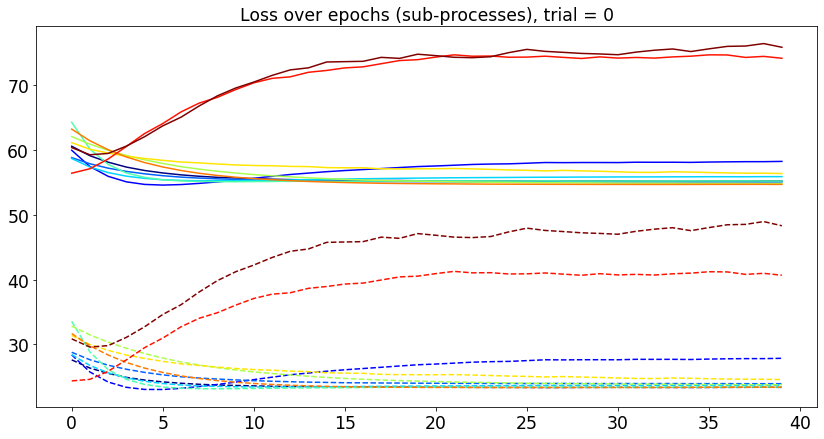

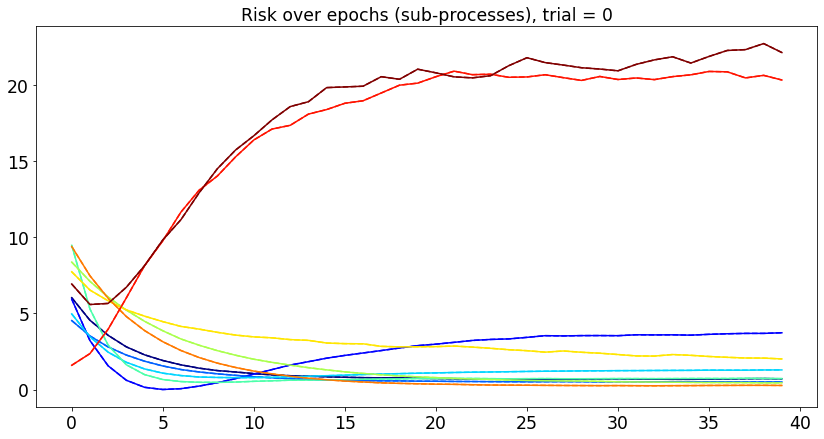

In [4]:
## Losses.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "quadratic_train"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "quadratic_test"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))

        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} tr".format(j),
                        ls="--")
        except FileNotFoundError:
            print("No training results found; not visualizing.")

        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} te".format(j),
                        ls="-")
        except FileNotFoundError:
            print("No test results found; not visualizing.")

        ax.tick_params(labelsize=my_fontsize)
        #ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Loss over epochs (sub-processes), trial = {}".format(trial_choice),
                     size=my_fontsize)
        plt.show()
        
    else:
        print("No loss results found; continuing.")


## Risks.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "risk_train"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "risk_test"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} tr".format(j),
                        ls="--")
        except FileNotFoundError:
            print("No training results found; not visualizing.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} te".format(j),
                        ls="-")
        except FileNotFoundError:
            print("No test results found; not visualizing.")

        ax.tick_params(labelsize=my_fontsize)
        #ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Risk over epochs (sub-processes), trial = {}".format(trial_choice),
                     size=my_fontsize)
        #ax.axhline(y=chance_level, linestyle="dotted", color="black")
        plt.show()
        
    else:
        print("No accuracy results found; continuing.")


### Boosted candidates

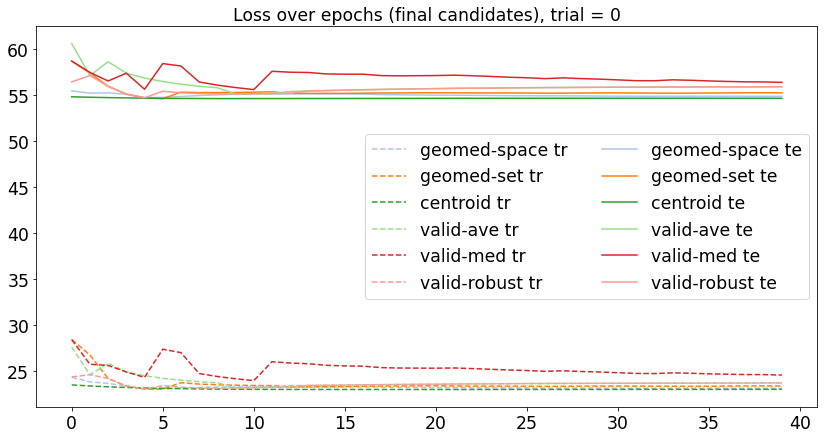

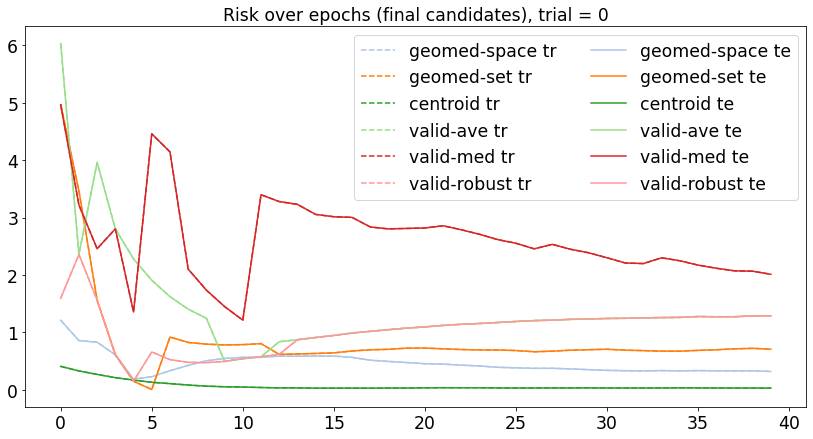

In [5]:
to_plot = ["geomed-space", "centroid", "geomed-set",
           "valid-ave", "valid-med", "valid-robust"]

## Losses.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "quadratic_train_rb"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "quadratic_test_rb"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} tr".format(todo_roboost[j]),
                            ls="--")
        except FileNotFoundError:
            print("No training results found; not visualizing.")

        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} te".format(todo_roboost[j]),
                            ls="-")
        except FileNotFoundError:
            print("No test results found; not visualizing.")
                

        ax.tick_params(labelsize=my_fontsize)
        ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Loss over epochs (final candidates), trial = {}".format(trial_choice),
                     size=my_fontsize)
        plt.show()
        
    else:
        print("No loss results found; continuing.")


## Risks.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "risk_train_rb"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "risk_test_rb"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} tr".format(todo_roboost[j]),
                            ls="--")
                
        except FileNotFoundError:
            print("No training results found; not visualizing.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} te".format(todo_roboost[j]),
                            ls="-")
                
        except FileNotFoundError:
            print("No test results found; not visualizing.")

        ax.tick_params(labelsize=my_fontsize)
        ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Risk over epochs (final candidates), trial = {}".format(trial_choice),
                     size=my_fontsize)
        #ax.axhline(y=chance_level, linestyle="dotted", color="black")
        plt.show()
        
    else:
        print("No accuracy results found; continuing.")



___

<a id="multitrial"></a>
## Visualize: boosted candidates over multiple trials

In [6]:
def agg_fn_all(arr, agg_type):
    if agg_type == "mean":
        return np.mean(arr, axis=0)
    elif agg_type == "sd":
        return np.std(arr, axis=0)
    else:
        raise ValueError


In [7]:
agg_todo = "mean" # "mean", "sd"
agg_fn = lambda array: agg_fn_all(arr=array, agg_type=agg_todo)

In [8]:
## First, a few lines of code to extract all the method names.
all_files = os.listdir(toread_dir)
names_raw = []
for s in all_files:
    split_hyphen = s.split("-")
    split_dot = s.split(".")
    if split_hyphen[0] == task_name and split_dot[-1] != "json":
        names_raw += ["-".join(split_hyphen[0:-1])]
names_raw = np.array(names_raw)
names_unique = np.unique(names_raw)
print("Unique names found:", names_unique)

Unique names found: ['default-linreg_SGD']


In [9]:
to_plot = ["geomed-space", "centroid", "geomed-set",
           "valid-ave", "valid-med", "valid-robust"]

### Single task, single model

No training results found; not collecting.
No test results found; not collecting.


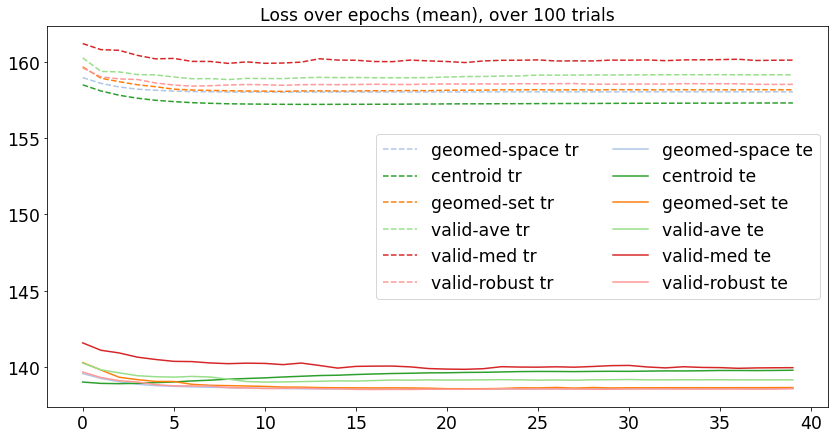

No training results found; not collecting.
No test results found; not collecting.


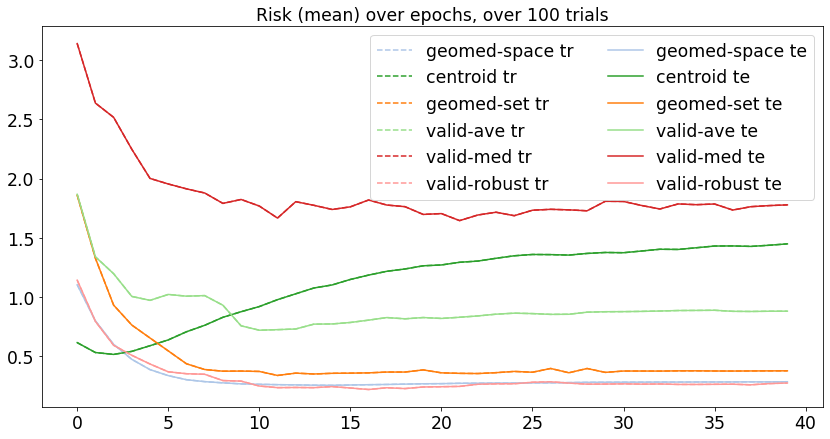

In [10]:
## Losses (gathering).
dict_train = {a: [] for a in to_plot}
dict_test = {a: [] for a in to_plot}
trial = 0
do_gathering = True

while do_gathering:
    
    toread_train = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "quadratic_train_rb"]))
    toread_test = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "quadratic_test_rb"]))
    
    do_gathering = os.path.isfile(toread_train) or os.path.isfile(toread_test)
    
    with ExitStack() as stack:
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_train[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No training results found; not collecting.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_test[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No test results found; not collecting.")
    
    ## If the current trial went through, increment to try the next one.
    if do_gathering:
        trial += 1

dict_train = {a:np.vstack(dict_train[a]) for a in dict_train.keys()}
dict_test = {a:np.vstack(dict_test[a]) for a in dict_test.keys()}

## Losses (visualization).

fig, ax = plt.subplots(1, 1, figsize=(14,7))

for mth in dict_train.keys():
    yval_array = dict_train[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} tr".format(mth),
                ls="--")
        
for mth in dict_test.keys():
    yval_array = dict_test[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} te".format(mth),
                ls="-")

ax.tick_params(labelsize=my_fontsize)
ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("Loss over epochs ({}), over {} trials".format(agg_todo, trial),
             size=my_fontsize)
plt.show()


## Risks (gathering).
dict_train = {a: [] for a in to_plot}
dict_test = {a: [] for a in to_plot}
trial = 0
do_gathering = True

while do_gathering:
    
    toread_train = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "risk_train_rb"]))
    toread_test = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "risk_test_rb"]))
    
    do_gathering = os.path.isfile(toread_train) or os.path.isfile(toread_test)
    
    with ExitStack() as stack:
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_train[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No training results found; not collecting.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float,
                               delimiter=",", ndmin=2)
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_test[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No test results found; not collecting.")
    
    ## If the current trial went through, increment to try the next one.
    if do_gathering:
        trial += 1

dict_train = {a:np.vstack(dict_train[a]) for a in dict_train.keys()}
dict_test = {a:np.vstack(dict_test[a]) for a in dict_test.keys()}

## Accuracies (visualization).

fig, ax = plt.subplots(1, 1, figsize=(14,7))

for mth in dict_train.keys():
    yval_array = dict_train[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} tr".format(mth),
                ls="--")
        
for mth in dict_test.keys():
    yval_array = dict_test[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} te".format(mth),
                ls="-")

ax.tick_params(labelsize=my_fontsize)
ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("Risk ({}) over epochs, over {} trials".format(agg_todo, trial),
             size=my_fontsize)
#ax.axhline(y=chance_level, linestyle="dotted", color="black")
plt.show()


___